In [85]:
import numpy as np
from shapely.geometry import Polygon, LineString
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.animation as mpl_animation
from IPython import display

from reading_utils import prepare_contours, load_data, get_contour_tensor
from shape_features import get_gibson_sphericity_index, get_sphericity_index, get_short_axis, get_long_axis, get_basal_midpoint, get_regional_areas_time, convert_to_polar, get_cumulative_areas, get_triangle_areas, get_spacial_heterogeneity_index, get_temporal_heterogeneity_index, get_region_angles, car2pol, get_local_ES

In [2]:
contour_dir = Path('../../raw_data/Results/')

contours = prepare_contours(
        load_data(contour_dir, only_norm=False),
        scale=True, center=True,
        interpolate_time_points=None,
        fourier_interpolate_kwargs=None,
        close_contours=False
    )

In [120]:
n_regions = 20
patient = contours[0]

contour_points_time = patient['coordinates']
ed_contour = contour_points_time[0]
contour_points_time_polar = convert_to_polar(contour_points_time)
region_areas_time = get_regional_areas_time(contour_points_time_polar, n_regions)
les_time = get_local_ES(region_areas_time)
r_ed, phi_ed = car2pol(ed_contour, [0,0])
phi_ed0 = phi_ed[0]
region_angles = get_region_angles(contour_points_time_polar[0], n_regions)
rg = (region_angles + phi_ed0) % (2 * np.pi)
rg = np.concatenate([[phi_ed0], rg])

figure = plt.figure()
plt.gca().set_aspect('equal')
plt.xlim(-7,7)
plt.plot(*ed_contour.T, color='black', linestyle='--')

area_texts = []
les_texts = []
for i, phi in enumerate(rg):
    r = 1
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    plt.plot([x * 0.1, x * 8], [y * 0.1, y * 8], color='black', linewidth=0.1)

for i in range(1, len(rg)):
    phi_prev = rg[i-1]
    phi_cur = rg[i]
    x1, x2 = r * np.cos(phi_prev), r * np.cos(phi_cur)
    y1, y2 = r * np.sin(phi_prev), r * np.sin(phi_cur)
    x, y = np.mean([x1, x2]), np.mean([y1, y2])
    text_x = x * 6 - 0.5
    text_y = y * 6
    dt = 0
    if np.sin(phi) > 0:
        text_x -= dt
    else:
        text_x += dt
    if np.cos(phi) > 0:
        text_y += dt
    else:
        text_y -= dt
    text = plt.text(text_x, text_y, f'{region_areas_time[0][i-1]:.2f}')
    
    les_text = plt.text(x * 4, y * 4, f'{les_time[i-1]:0>2d}')
    les_texts.append(les_text)
    area_texts.append(text)

xdata, ydata = [], []
line, = plt.plot(xdata, ydata, color='orange')
frame_text = plt.text(0.5, 0.5, 'a', fontsize=12,
                      horizontalalignment='center',
                      verticalalignment='center',
                      transform=plt.gca().transAxes
                     )
def animate(j):
    frame_text.set_text(f"{j:0>2d}/{len(contour_points_time)}\n{patient['end_systolic_id']:0>2d}")
    x, y = contour_points_time[j].T
    line.set_xdata(x)
    line.set_ydata(y)
    for i, text in enumerate(area_texts):
        text.set_text(f'{region_areas_time[j][i]:.2f}')
        time_distance = les_time[i] - j
        if time_distance >= 0:
            les_texts[i].set_color((1-time_distance/les_time[i], 0, 0, 1))
        else:
            dist_from_end = len(region_areas_time)-les_time[i]
            les_texts[i].set_color((0, 0, 1-np.abs(time_distance)/dist_from_end, 1))
        # text.set_color((1-time_distance/len(region_areas_time),0,0,1))
        # if les_time[i] == j:
        #     text.set_color((1,0,0,1))
        # else:
        #     text.set_color((0,0,0,1))
    return line,

animation = mpl_animation.FuncAnimation(
    figure,
    func=animate,
    frames=np.arange(0, len(contour_points_time)),
    # frames=np.arange(0, 5),
    interval=200
)
video_n = animation.to_html5_video()
html_code_n = display.HTML(video_n)
display.display(html_code_n)
plt.close()

In [3]:
for patient in contours:
    patient_info = f"{patient['patient_code']}_{patient['operation_status']}_{patient['wall_type']}"
    es_id = patient['end_systolic_id']
    contour_points_time = patient['coordinates']
    sh = get_spacial_heterogeneity_index(contour_points_time)
    th = get_temporal_heterogeneity_index(contour_points_time, es_id)
    print(patient_info, sh, th)

01_0m_endo 0.7027256253894324 0.6531867210545417
01_0m_epi 0.9031545213281372 0.6578738430668889
01_6m_endo 0.9455793392983933 0.624435751404163
01_6m_epi 0.943074092474387 0.6120595641287406
01_np_endo 0.9841195010074594 0.6652126008806865
01_np_epi 1.1383863536966776 0.5751347785220738
02_np_endo 1.3780932301343756 0.7653980147498337
02_np_epi 1.3523296580653297 0.7250918987665343
03_0m_endo 1.1202574303851154 0.6011100842053253
03_0m_epi 1.221104115659968 0.6358535327577617
03_6m_endo 1.0856182759735924 0.3051674824527223
03_6m_epi 1.162984921220331 0.47719470828955285
03_np_endo 0.9861366359143491 0.6652266697754953
03_np_epi 0.9828365750306438 0.40524181807753346
04_np_endo 1.1303329638910486 0.4642348364471651
04_np_epi 1.159852873323382 0.6341141017900349
05_0m_endo 1.2779865641955017 0.4963639288686568
05_0m_epi 1.0807314240408474 0.7175534388052975
05_6m_endo 1.2099534396154956 0.7413412013772768
05_6m_epi 1.4540271298995837 0.7347449020863501
05_np_endo 1.0795300512979353 0.4

In [7]:
print(contour_points_time.shape, contour_points_time_polar.shape)

(67, 49, 2) (67, 49, 2)


In [53]:
patient_n = 0
patient = contours[patient_n]
patient_info = f"{patient['patient_code']}_{patient['operation_status']}_{patient['wall_type']}"
print()
contour_points_time = patient['coordinates']
contour_points_time_polar = convert_to_polar(contour_points_time)
n_regions = 20
regional_areas_time = get_regional_areas_time(contour_points_time_polar, n_regions)

Text(0.5, 1.0, '01_0m_endo')

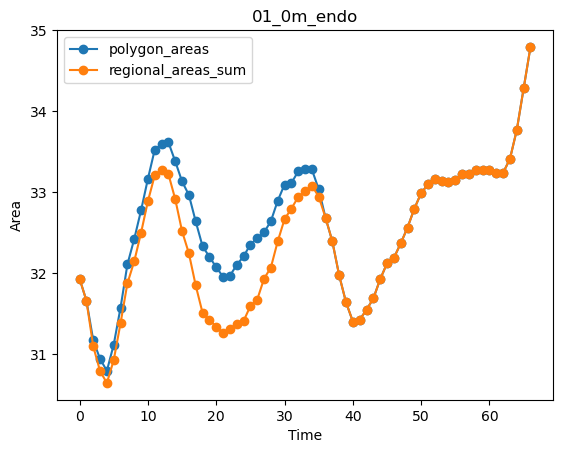

In [54]:
areas = [Polygon(np.concatenate([frame, [[0,0]]])).area for frame in contour_points_time]
plt.plot(areas, label='polygon_areas', marker='o', zorder=1)
plt.plot(np.sum(regional_areas_time, axis=1), label='regional_areas_sum', marker='o', zorder=2);
plt.xlabel('Time')
plt.ylabel('Area')
plt.legend()
plt.title(patient_info)

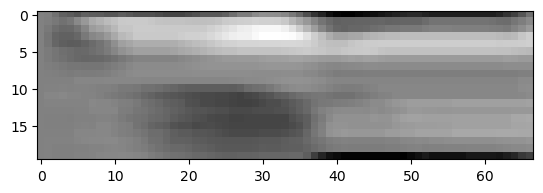

In [45]:
plt.imshow(regional_areas_time.T, cmap='gray')

In [48]:
local_es = np.argmin(regional_areas_time, axis=0)
print(local_es.shape)
regional_areas_time[(local_es, np.arange(len(local_es)))]

(20,)


array([0.73879273, 1.38555826, 1.39714632, 1.38914187, 1.35428647,
       1.43283913, 1.41990459, 1.51783759, 1.55727015, 1.59655894,
       1.36159579, 1.18111442, 1.17081005, 1.23122623, 1.1836741 ,
       1.20033938, 1.23249369, 1.31068323, 1.32362589, 0.74258123])

In [14]:
ids = []
for i, contour in enumerate(contours):
    if contour['patient_code'] == '05':
        print(i, contour['operation_status'], contour['wall_type'])
        ids.append(i)

16 0m endo
17 0m epi
18 6m endo
19 6m epi
20 np endo
21 np epi


In [52]:
import matplotlib.pyplot as plt
import matplotlib.animation as mpl_animation
from IPython import display

contour = contours[patient_n]
print(contour['coordinates'].shape)
figure, ax = plt.subplots()
x, y = contour['coordinates'][0].T
line, = plt.plot(x, y, marker='o', color='blue')
ax.set_aspect('equal')
ax.set_xlim(-6,6)
def animate(j):
    x, y = contour['coordinates'][j].T
    line.set_xdata(x)
    line.set_ydata(y)
    return line,

animation = mpl_animation.FuncAnimation(
    figure,
    func=animate,
    frames=np.arange(0, len(contour['coordinates'])),
    interval=50
)
video_n = animation.to_html5_video()
html_code_n = display.HTML(video_n)
display.display(html_code_n)
plt.close()

(51, 49, 2)


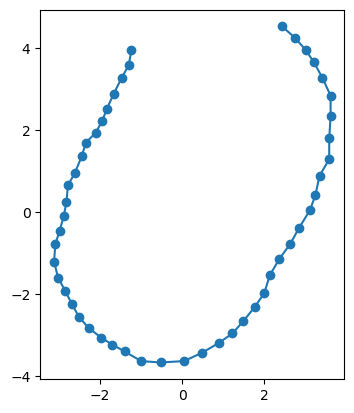

In [6]:
plt.plot(*contour['coordinates'][0].T, marker='o')
plt.gca().set_aspect('equal')

In [3]:
n = 96

frame = 10
contour_in_time = contours[n]['coordinates']
contour = contour_in_time[frame]
contour_closed = np.r_[contour, contour[[0]]]
contour_poly = Polygon(contour)
print(contours[n]['patient_code'], contours[n]['operation_status'], contours[n]['wall_type'])

23 0m endo


In [30]:
ed_contour = contour_in_time[0]
center = np.mean(ed_contour, axis=0)
total_area = Polygon(np.r_[ed_contour, [[0,0]]]).area
n_sectors = 20
part_area = total_area / n_sectors
print(total_area, part_area)

28.668550017842268 1.4334275008921133


28.668550017842264 28.668550017842268


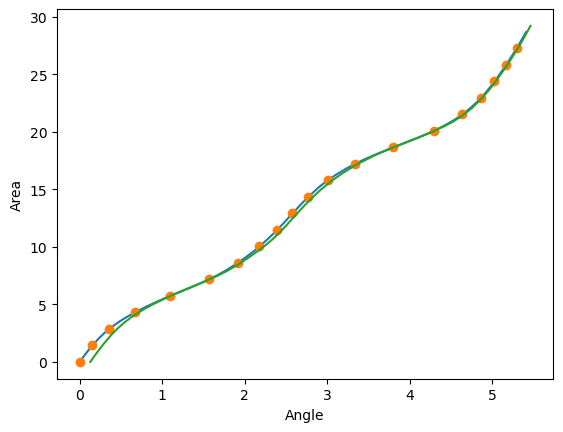

In [67]:
def car2pol(coords, center=None):
    if center is None:
        center = np.mean(coords, axis=0)
    coords_c = np.subtract(coords, center)
    r = np.linalg.norm(coords_c, axis=1)
    angle = np.arctan2(coords_c[:,1], coords_c[:,0])
    return r, angle

def make_contour_angle_increasing(angle):
    angle = np.array(angle)
    angle[np.where(angle < angle[0])] += 2 * np.pi
    return angle
    
r, phi = car2pol(ed_contour, [0,0])

# plt.plot(phi)
phi_0 = phi[0]
phi = make_contour_angle_increasing(phi) - phi_0
# plt.plot(phi)

areas_tr = r[:-1] * r[1:] * np.sin(np.diff(phi)) / 2
areas_tr = np.array([0, *areas_tr])

print(np.sum(areas_tr), total_area)

plt.plot(phi, np.cumsum(areas_tr))
# plt.plot(np.cumsum(areas_tr), phi)
plt.xlabel('Angle')
plt.ylabel('Area')

import scipy.interpolate
angle_from_area_function = scipy.interpolate.interp1d(
    np.cumsum(areas_tr), phi
)

sample_area_points = np.linspace(0, np.sum(areas_tr), n_sectors, endpoint=False)
sample_angles = angle_from_area_function(sample_area_points)
plt.plot(sample_angles, sample_area_points, linestyle='', marker='o')

r2, phi2 = car2pol(contour_in_time[10])
phi2 = make_contour_angle_increasing(phi2) - phi_0
areas_tr2 = r2[:-1] * r[1:] * np.sin(np.diff(phi2)) / 2
areas_tr2 = np.array([0, *areas_tr2])
plt.plot(phi2, np.cumsum(areas_tr2))

# areas_right = r[1:] ** 2 * np.diff(phi) / 2
# areas_left = r[:-1] ** 2 * np.diff(phi) / 2
# plt.plot(np.cumsum(areas_left), label='left')
# plt.plot(np.cumsum(areas_right), label='right')
# plt.legend()
# plt.plot(np.cumsum(areas_tr))
# print(total_area, np.sum(areas_left), np.sum(areas_right), np.sum(areas_tr))

In [57]:
dir(angle_from_area_function)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_call',
 '_call_linear',
 '_call_linear_np',
 '_call_nan_spline',
 '_call_nearest',
 '_call_previousnext',
 '_call_spline',
 '_check_and_update_bounds_error_for_extrapolation',
 '_check_bounds',
 '_evaluate',
 '_extrapolate',
 '_fill_value_above',
 '_fill_value_below',
 '_fill_value_orig',
 '_finish_y',
 '_kind',
 '_prepare_x',
 '_reshape_yi',
 '_set_dtype',
 '_set_yi',
 '_y',
 '_y_axis',
 '_y_extra_shape',
 'axis',
 'bounds_error',
 'copy',
 'dtype',
 'fill_value',
 'x',
 'y']

In [62]:
angle_from_area_function.fill_value

array(nan)

[[-1.57645213 -3.6593476 ]
 [ 0.83298152  4.3913349 ]]


Text(0.5, 1.0, '23_0m_endo frame=10')

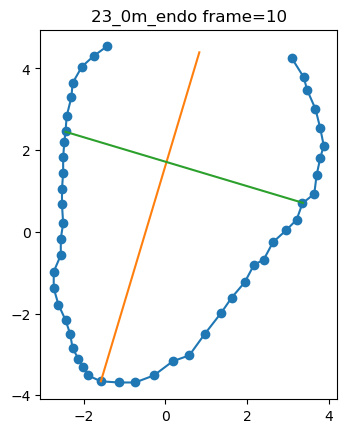

In [419]:
plt.plot(*contour.T, marker='o')
long_axis_line = get_long_axis(contour)
short_axis_line = get_short_axis(contour, long_axis_line)
print(long_axis_line)
# perpendicular
plt.plot(*long_axis_line.T)
plt.plot(*short_axis_line.T)
plt.gca().set_aspect('equal')
plt.title(f"{contours[n]['patient_code']}_{contours[n]['operation_status']}_{contours[n]['wall_type']} frame={frame}")

(array([4.45318916, 4.29987009, 4.10790137, 3.82754608, 3.60047488,
        3.30530633, 3.04504148, 2.93745882, 2.73717526, 2.61913463,
        2.53509167, 2.46509479, 2.40614498, 2.47108468, 2.58413874,
        2.76721897, 2.9300449 , 3.09946654, 3.22214789, 3.36557764,
        3.58012327, 3.68454911, 3.79919881, 3.96741829, 3.98447314,
        3.86143861, 3.76163709, 3.52604269, 3.25538796, 3.0490233 ,
        2.83219831, 2.59395741, 2.4438442 , 2.37241974, 2.35885443,
        2.40784283, 2.55738491, 2.74801486, 3.01166335, 3.25843493,
        3.50876697, 3.78508811, 4.05784372, 4.32292098, 4.48582472,
        4.61433907, 4.7814036 , 4.92864558, 5.12818617]),
 array([ 1.73766247,  1.82610548,  1.88969091,  1.97061735,  2.04190485,
         2.12860246,  2.21804926,  2.31067466,  2.42668904,  2.55577264,
         2.67929555,  2.84235605,  3.007068  , -3.13206005, -2.99798752,
        -2.87983877, -2.77056608, -2.64879655, -2.53326229, -2.43397225,
        -2.34374893, -2.24418939, -2.1

#### plt.plot(*contour.T, marker='o')
basal_midpoint = np.mean([contour[0], contour[-1]], axis=0)
long_axis_line = np.array([contour[4], basal_midpoint])
long_axis_vector = long_axis_line[1] - long_axis_line[0]
la_len = np.linalg.norm(long_axis_line)

short_point = long_axis_line[0] + long_axis_vector * 2 / 3
normal_to_la = np.array([1, -long_axis_vector[0]/long_axis_vector[1]])
normal_to_la = normal_to_la / np.linalg.norm(normal_to_la)

# la_normal_linestring = LineString(np.array([-1,0,1]) * normal_to_la[...,None])
la_normal_linestring = LineString(
    [short_point - normal_to_la * la_len, short_point, short_point + normal_to_la * la_len]
)
short_axis_linestring = la_normal_linestring.intersection(contour_poly)
short_axis_line = np.array(short_axis_linestring.xy).T[:,:2]
short_axis_vector = short_axis_line[1] - short_axis_line[0]
sa_len = np.linalg.norm(short_axis_vector)
print(la_len, sa_len)

# perpendicular
plt.plot(*long_axis_line.T)
plt.plot(*short_point, marker='o', markerfacecolor='red', markeredgecolor=(0,0,0,0))
plt.plot(*np.array([short_point, short_point + normal_to_la]).T)
plt.plot(*short_axis_line.T)
plt.gca().set_aspect('equal')

In [ ]:
from scipy.interpolate import splprep, splev



tck, u = splprep(contour_closed.T, s=0, per=True)
y = splev(np.linspace(0,1,52), tck)
y = np.array(y)
print(y.shape)

plt.plot(*contour.T, label='orig', marker='o')
plt.plot(*y, label='interpolation', marker='o', markersize=3)
plt.legend()
plt.gca().set_aspect('equal')

In [ ]:
from scipy.interpolate import splprep, splev
contour = contours[0]['coordinates'][0]
contour_closed = np.r_[contour, contour[[0]]]

tck, u = splprep(contour.T, s=0)
n = 6
y = splev(np.linspace(0,1,8*n + 1), tck)
y_prime = splev(np.linspace(0,1,8*n + 1), tck, der=1)
y = np.array(y)
print(y.shape)

x_prime = splev(u[4], tck, der=1)
x_prime2 = splev(u[4], tck, der=2)

x_c = contour[4][0] + x_prime[1] * (x_prime[0] ** 2 + x_prime[1] ** 2) / (x_prime[1] * x_prime2[0] - x_prime[0] * x_prime2[1])
y_c = contour[4][1] - x_prime[0] * (x_prime[0] ** 2 + x_prime[1] ** 2) / (x_prime[1] * x_prime2[0] - x_prime[0] * x_prime2[1])
k = (x_prime[0] * x_prime2[1] - x_prime2[0] * x_prime[1]) / (x_prime[0] ** 2 + x_prime[1] ** 2) ** (3/2)
r = 1 / np.abs(k)

print(x_c, y_c, k, r)
plt.plot(*contour.T, label='orig', marker='o')
plt.plot(*y, label='interpolation', marker='o', markersize=3)
# plt.plot(x_c, y_c, color='red', marker='o')
circle = plt.Circle((x_c, y_c), radius=r, edgecolor='red', facecolor=(0,0,0,0))
plt.gca().add_patch(circle)
plt.legend()
plt.gca().set_aspect('equal')

In [ ]:
from scipy.interpolate import splprep, splev
contour = contours[0]['coordinates'][0]
contour_closed = np.r_[contour, contour[[0]]]

tck, u = splprep(contour.T, s=0)
n = 5
y = splev(np.linspace(0,1,8*n + 1), tck)
y_prime = splev(np.linspace(0,1,8*n + 1), tck, der=1)
y = np.array(y)
print(y.shape)

x_prime = splev(u[4], tck, der=1)
x_prime2 = splev(u[4], tck, der=2)

x_c = contour[4][0] + x_prime[1] * (x_prime[0] ** 2 + x_prime[1] ** 2) / (x_prime[1] * x_prime2[0] - x_prime[0] * x_prime2[1])
y_c = contour[4][1] - x_prime[0] * (x_prime[0] ** 2 + x_prime[1] ** 2) / (x_prime[1] * x_prime2[0] - x_prime[0] * x_prime2[1])
k = (x_prime[0] * x_prime2[1] - x_prime2[0] * x_prime[1]) / (x_prime[0] ** 2 + x_prime[1] ** 2) ** (3/2)
r = 1 / np.abs(k)

basal_midpoint = np.mean([contour[0], contour[-1]], axis=0)
plt.plot(*basal_midpoint, marker='o', color='green')

print(x_c, y_c, k, r)
plt.plot(*contour.T, label='orig', marker='o')
plt.plot(*y, label='interpolation', marker='o', markersize=3)
# plt.plot(x_c, y_c, color='red', marker='o')
circle = plt.Circle((x_c, y_c), radius=r, edgecolor='red', facecolor=(0,0,0,0))
plt.gca().add_patch(circle)
plt.legend()
plt.gca().set_aspect('equal')

In [ ]:
def parabola(x, x_0, k, der=0):
    return x_0 + k * x ** 2

from scipy.optimize import curve_fit

xdata, ydata = contour[[3,4,5]].T
popt, pcov = curve_fit(parabola, xdata, ydata)

plt.plot(*contour.T, label='orig', marker='o')
xs = np.linspace(xdata[0], xdata[-1], 100, endpoint=True)
plt.plot(xs, parabola(xs, *popt))
plt.gca().set_aspect('equal')

In [ ]:
popt

In [ ]:
pcov